In [1]:
import requests
import pandas as pd

# Define chain mapping for reference
CHAIN_IDS = {
    'eth': 1,
    'arbitrum': 42161,
    'bsc': 56,
    'base': 8453,
    'mantle': 5000,
    'op': 10,  # Optimism
    # Add more chains as needed
}
# Initialize lists to store DataFrames from each chain
active_dfs = []
inactive_dfs = []

# Iterate through all chains
for chain_name, chain_id in CHAIN_IDS.items():
    print(f"\nFetching data for {chain_name}...")
    
    # Fetch both active and inactive markets
    for market_type in ['active', 'inactive']:
        url = f"https://api-v2.pendle.finance/core/v1/{chain_id}/markets/{market_type}"
        headers = {"accept": "application/json"}
        
        response = requests.get(url, headers=headers)
        
        # Check if request was successful
        if response.status_code == 200:
            data = response.json()
            print(f"✓ Request successful for {chain_name} chain ({market_type} markets)!")
            
            # Extract the 'markets' list from the response data
            markets = data['markets']
            
            if markets:  # Check if markets list is not empty
                # Create DataFrame from the list of dictionaries
                df = pd.DataFrame(markets)
                df['chain'] = chain_name  # Add chain name
                df.insert(0, 'chain', df.pop('chain'))
                
                # Remove chain ID prefix from specified columns
                prefix = f"{chain_id}-"
                for col in ['pt', 'yt', 'sy', 'underlyingAsset']:
                    df[col] = df[col].str.replace(prefix, '')
                
                # Add to appropriate list
                if market_type == 'active':
                    active_dfs.append(df)
                else:
                    inactive_dfs.append(df)
                    
                print(f"Found {len(markets)} {market_type} markets")
            else:
                print(f"No {market_type} markets found for {chain_name}")
        else:
            print(f"✗ Request failed for {chain_name} ({market_type}) with status code: {response.status_code}")
if active_dfs:
    active_market = pd.concat(active_dfs, ignore_index=True)
    active_market['expiry'] = pd.to_datetime(active_market['expiry']).dt.date
    print("\nTotal active markets found:", len(active_market))

# Combine inactive DataFrames
if inactive_dfs:
    inactive_market = pd.concat(inactive_dfs, ignore_index=True)
    inactive_market['expiry'] = pd.to_datetime(inactive_market['expiry']).dt.date
    print("Total inactive markets found:", len(inactive_market))


Fetching data for eth...
✓ Request successful for eth chain (active markets)!
Found 55 active markets
✓ Request successful for eth chain (inactive markets)!
Found 109 inactive markets

Fetching data for arbitrum...
✓ Request successful for arbitrum chain (active markets)!
Found 12 active markets
✓ Request successful for arbitrum chain (inactive markets)!
Found 47 inactive markets

Fetching data for bsc...
✓ Request successful for bsc chain (active markets)!
Found 2 active markets
✓ Request successful for bsc chain (inactive markets)!
Found 5 inactive markets

Fetching data for base...
✓ Request successful for base chain (active markets)!
Found 7 active markets
✓ Request successful for base chain (inactive markets)!
No inactive markets found for base

Fetching data for mantle...
✓ Request successful for mantle chain (active markets)!
Found 1 active markets
✓ Request successful for mantle chain (inactive markets)!
Found 4 inactive markets

Fetching data for op...
✓ Request successful fo

In [2]:
# Add these imports at the top of your notebook
import ipywidgets as widgets
from IPython.display import display, HTML

# Rest of your code remains the same...

# Define the MarketSelector class in your notebook
class MarketSelector:
    def __init__(self, active_market_df, inactive_market_df):
        """Initialize the market selector with active and inactive market DataFrames"""
        self.active_market = active_market_df
        self.inactive_market = inactive_market_df
        self.selected_market_data = None
        
        # Create UI elements
        self.market_type_dropdown = widgets.Dropdown(
            options=['active', 'inactive'],
            description='Market Type:',
            style={'description_width': 'initial'}
        )
        
        self.chain_dropdown = widgets.Dropdown(
            description='Chain:',
            style={'description_width': 'initial'}
        )
        
        self.market_dropdown = widgets.Dropdown(
            description='Market:',
            style={'description_width': 'initial'}
        )
        
        self.expiry_dropdown = widgets.Dropdown(
            description='Expiry:',
            style={'description_width': 'initial'}
        )
        
        self.lock_button = widgets.Button(
            description='Lock Selection',
            button_style='success',
            tooltip='Lock in this market selection for further analysis'
        )
        
        self.output = widgets.Output()
        self.lock_output = widgets.Output()
        
        # Connect callbacks
        self.market_type_dropdown.observe(self.update_chains, 'value')
        self.chain_dropdown.observe(self.update_markets, 'value')
        self.market_dropdown.observe(self.update_expiries, 'value')
        self.market_dropdown.observe(self.show_market_details, 'value')
        self.expiry_dropdown.observe(self.show_market_details, 'value')
        self.lock_button.on_click(self.lock_selection)
        
        # Initial update
        self.update_chains()
        
    def get_current_df(self):
        """Return the appropriate DataFrame based on market type selection"""
        return self.active_market if self.market_type_dropdown.value == 'active' else self.inactive_market
    
    def update_chains(self, *args):
        """Update available chains based on market type"""
        current_df = self.get_current_df()
        self.chain_dropdown.options = sorted(current_df['chain'].unique())
        if self.chain_dropdown.options:
            self.chain_dropdown.value = self.chain_dropdown.options[0]
    
    def update_markets(self, *args):
        """Update available markets based on selected chain"""
        current_df = self.get_current_df()
        self.market_dropdown.options = sorted(
            current_df[current_df['chain'] == self.chain_dropdown.value]['name'].unique()
        )
        if self.market_dropdown.options:
            self.market_dropdown.value = self.market_dropdown.options[0]
    
    def update_expiries(self, *args):
        """Update available expiry dates based on selected chain and market"""
        current_df = self.get_current_df()
        self.expiry_dropdown.options = sorted(
            current_df[
                (current_df['chain'] == self.chain_dropdown.value) & 
                (current_df['name'] == self.market_dropdown.value)
            ]['expiry'].unique()
        )
        if self.expiry_dropdown.options:
            self.expiry_dropdown.value = self.expiry_dropdown.options[0]
    
    def show_market_details(self, *args):
        """Display details for selected market"""
        self.output.clear_output()
        with self.output:
            current_df = self.get_current_df()
            selected_market = current_df[
                (current_df['chain'] == self.chain_dropdown.value) & 
                (current_df['name'] == self.market_dropdown.value) &
                (current_df['expiry'] == self.expiry_dropdown.value)
            ].iloc[0]
            
            expiry_date = pd.to_datetime(selected_market['expiry']).strftime('%Y-%m-%d')
            
            html = f"""
            <h3>Market Details:</h3>
            <table>
                <tr><td><b>Market Type:</b></td><td>{self.market_type_dropdown.value}</td></tr>
                <tr><td><b>Chain:</b></td><td>{selected_market['chain']}</td></tr>
                <tr><td><b>Name:</b></td><td>{selected_market['name']}</td></tr>
                <tr><td><b>Expiry:</b></td><td>{expiry_date}</td></tr>
                <tr><td><b>Address:</b></td><td>{selected_market['address']}</td></tr>
                <tr><td><b>PT:</b></td><td>{selected_market['pt']}</td></tr>
                <tr><td><b>YT:</b></td><td>{selected_market['yt']}</td></tr>
                <tr><td><b>SY:</b></td><td>{selected_market['sy']}</td></tr>
                <tr><td><b>Underlying Asset:</b></td><td>{selected_market['underlyingAsset']}</td></tr>
            </table>
            """
            display(HTML(html))
    
    def lock_selection(self, button):
        """Store the selected market data for further use"""
        current_df = self.get_current_df()
        self.selected_market_data = current_df[
            (current_df['chain'] == self.chain_dropdown.value) & 
            (current_df['name'] == self.market_dropdown.value) &
            (current_df['expiry'] == self.expiry_dropdown.value)
        ].iloc[0].to_dict()
        
        self.lock_output.clear_output()
        with self.lock_output:
            print(f"✅ Market data locked for: {self.selected_market_data['name']} (Expiry: {self.selected_market_data['expiry']})")
            print(f"Market Type: {self.market_type_dropdown.value}")
            print("\nYou can now access the data using the selected_market_data property")
    
    def display(self):
        """Display the market selector UI"""
        ui = widgets.VBox([
            self.market_type_dropdown,
            self.chain_dropdown,
            self.market_dropdown,
            self.expiry_dropdown,
            self.lock_button,
            self.output,
            self.lock_output
        ])
        display(ui)

# Create the selector
selector = MarketSelector(active_market, inactive_market)

# Display the UI
selector.display()


In [6]:
class PendleHistoricalData:
    def __init__(self):
        self.CHAIN_IDS = {
            'eth': 1,
            'arbitrum': 42161,
            'bsc': 56,
            'base': 8453,
            'mantle': 5000,
            'op': 10
        }
        
    def fetch_market_history(self, chain_id, market_address):
        """Fetch historical data for a single market"""
        url = f"https://api-v2.pendle.finance/core/v1/{chain_id}/markets/{market_address}/historical-data"
        response = requests.get(url, params={"time_frame": "hour"}, headers={"accept": "application/json"})
        
        if response.status_code == 200:
            data = response.json()
            return pd.DataFrame({
                'timestamp': pd.to_datetime(data['timestamp'], unit='s'),
                'maxApy': data['maxApy'],
                'baseApy': data['baseApy'],
                'underlyingApy': data['underlyingApy'],
                'impliedApy': data['impliedApy'],
                'tvl': data['tvl']
            }).sort_values('timestamp')
        return None

    def fetch_market_data(self, market_dict):
        """Fetch historical data for a single market from dictionary"""
        print(f"Fetching data for {market_dict['name']} on {market_dict['chain']}")
        history = self.fetch_market_history(
            self.CHAIN_IDS[market_dict['chain']], 
            market_dict['address']
        )
        
        if history is not None:
            history['market_name'] = market_dict['name']
            history['chain'] = market_dict['chain']
            history['market_address'] = market_dict['address']
            return history
        return None

# Usage:
pendle = PendleHistoricalData()

# Fetch data for active and inactive markets
active_history = pendle.fetch_market_data(active_market)
inactive_history = pendle.fetch_market_data(inactive_market)

Fetching data for sUSDe on eth
Fetching data for sUSDe on eth


In [8]:
active_history = active_history.iloc[24:]
inactive_history = inactive_history.iloc[24:]
# First, let's combine both histories using concat and then handle duplicates
# First, let's combine both histories using concat and then handle duplicates
combined_history = pd.concat([active_history, inactive_history])

# Sort by timestamp and drop duplicates, keeping the first occurrence
combined_history = (combined_history
    .sort_values('timestamp')  # Sort by timestamp first
    .drop_duplicates(subset='timestamp', keep='first')  # Remove duplicates
    .reset_index(drop=True))  # Reset index to have clean sequential indices



In [9]:
# Fetch Binance funding rates
def get_binance_funding_rates(symbol, limit=1000):
    url = f"https://fapi.binance.com/fapi/v1/fundingRate"
    params = {
        "symbol": symbol,
        "limit": limit
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        df = pd.DataFrame(response.json())
        df['fundingTime'] = pd.to_datetime(df['fundingTime'], unit='ms')
        df['fundingRate'] = df['fundingRate'].astype(float)
        return df
    else:
        print(f"Failed to fetch funding rates for {symbol}: {response.status_code}")
        return None

# Fetch funding rates for both BTC and ETH
btc_funding = get_binance_funding_rates("BTCUSDT")
eth_funding = get_binance_funding_rates("ETHUSDT")

# Combine the data
if btc_funding is not None and eth_funding is not None:
    btc_funding['symbol'] = 'BTC'
    eth_funding['symbol'] = 'ETH'
    funding_rates = pd.concat([btc_funding, eth_funding], ignore_index=True)
    

In [10]:
# Transform funding rates from long to wide format
funding_rates_wide = funding_rates.pivot(
    index='fundingTime',
    columns='symbol',
    values='fundingRate'
)

# Convert to hourly data by resampling and forward filling
funding_rates_hourly = funding_rates_wide.resample('1h').ffill()  # Changed from 8H to 1h

# Since funding rates are per 8 hours, divide by 8 to get hourly rates
for col in funding_rates_hourly.columns:
    funding_rates_hourly[col] = funding_rates_hourly[col] / 8

# Rename columns to be precise about the rate period
funding_rates_hourly.columns = [f'{col}_funding_hourly' for col in funding_rates_hourly.columns]

# Sort by index
funding_rates_hourly = funding_rates_hourly.sort_index()

In [11]:
# First, drop any existing funding rate columns from combined_history
columns_to_drop = [col for col in combined_history.columns if 'funding_hourly' in col]
combined_history = combined_history.drop(columns=columns_to_drop, errors='ignore')

# Then merge with funding rates
fulldf = pd.merge(
    combined_history,
    funding_rates_hourly[['BTC_funding_hourly', 'ETH_funding_hourly']],
    left_on='timestamp',
    right_index=True,
    how='left'
).dropna()

# Verify the columns
print("Columns in final dataframe:", fulldf.columns.tolist())

Columns in final dataframe: ['timestamp', 'maxApy', 'baseApy', 'underlyingApy', 'impliedApy', 'tvl', 'market_name', 'chain', 'market_address', 'BTC_funding_hourly', 'ETH_funding_hourly']


In [12]:
from dune_client.client import DuneClient
dune = DuneClient("cpmPhIm01CTHgJ8WvkNobqtpfqY9AKUL")
query_result = dune.get_latest_result(4512869)
dune_df = pd.DataFrame(query_result.result.rows)

In [14]:
# First rename the columns
dune_df = dune_df.rename(columns={
    'hour': 'timestamp',
    'current_supply': 'USDE_supply',
    'max_staked': 'sUSDE_supply'
})

# Then convert the timestamp and remove timezone
dune_df['timestamp'] = pd.to_datetime(dune_df['timestamp']).dt.tz_localize(None)

# Merge with existing merged_data
fulldf = pd.merge(
    fulldf,
    dune_df,
    on='timestamp',
    how='left'
)
fulldf['USDE_sUSDE_ratio'] = fulldf['sUSDE_supply'] / fulldf['USDE_supply']


In [15]:
import numpy as np
fulldf = fulldf.drop(columns=['chain', 'market_address', 'market_name'])
# Convert all columns except 'timestamp' to numeric
numeric_columns = [col for col in fulldf.columns if col != 'timestamp']
# Create a copy to avoid modifying the original dataframe
fulldf = fulldf.copy()
# Convert each column to numeric
for col in numeric_columns:
    fulldf[col] = pd.to_numeric(fulldf[col], errors='coerce')


Target
Implied APY: 72-hour forward prediction
Predictors
| Variable | Description | Scale |
|----------|-------------|-------|
| TVL | Total value locked | ~100M USD |
| BTC_funding_hourly | Bitcoin funding rate | ~0.000015 |
| ETH_funding_hourly | Ethereum funding rate | ~0.000015 |
| USDE_supply | Total USDE minted | Billions |
| sUSDE_supply | Total USDE staked | Subset of supply |
| USDE_sUSDE_ratio | Staking participation ratio | USDE/sUSDE |

In [17]:
def get_ena_price_data_extended(start_time=None, end_time=None, interval='1h'):
    """
    Fetch ENA/USDT hourly price data from Binance with pagination support
    
    Args:
        start_time (int): Start time in milliseconds (default: None)
        end_time (int): End time in milliseconds (default: None)
        interval (str): Time interval (default: '1h')
    """
    url = "https://api.binance.com/api/v3/klines"
    all_data = []
    
    # If no end_time specified, use current time
    if end_time is None:
        end_time = int(time.time() * 1000)
    
    # If no start_time specified, use timestamp from merged_data
    if start_time is None:
        start_time = int(fulldf['timestamp'].min().timestamp() * 1000)
    
    current_start = start_time
    
    while current_start < end_time:
        params = {
            "symbol": "ENAUSDT",
            "interval": interval,
            "limit": 1000,
            "startTime": current_start,
            "endTime": end_time
        }
        
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            if not data:  # If no more data
                break
                
            all_data.extend(data)
            
            # Update start_time to the last timestamp + 1
            current_start = data[-1][0] + 1
            
            # Add a small delay to avoid hitting rate limits
            time.sleep(0.1)
        else:
            print(f"Failed to fetch data: {response.status_code}")
            break
    
    if all_data:
        df = pd.DataFrame(all_data, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume',
            'close_time', 'quote_volume', 'trades', 'taker_buy_volume',
            'taker_buy_quote_volume', 'ignore'
        ])
        
        # Convert timestamp and keep relevant columns
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df = df[['timestamp', 'close', 'volume']].copy()
        df['close'] = df['close'].astype(float)
        df['volume'] = df['volume'].astype(float)
        df = df.rename(columns={
            'close': 'ena_price',
            'volume': 'ena_volume'
        })
        
        return df
    else:
        return None

# Import time if not already imported
import time

# Fetch extended ENA price data
ena_data = get_ena_price_data_extended()

# Print the date range and number of rows
if ena_data is not None:
    print(f"Data range: {ena_data['timestamp'].min()} to {ena_data['timestamp'].max()}")
    print(f"Total rows: {len(ena_data)}")

Data range: 2024-05-21 07:00:00 to 2025-01-16 16:00:00
Total rows: 5770


In [18]:
# Merge ena_data with merged_data
fulldf = pd.merge(
    fulldf,
    ena_data,
    on='timestamp',
    how='left'
)
fulldf = fulldf.drop(columns=['maxApy', 'baseApy', 'tvl', 'ena_volume'])



In [19]:
# Add APY boundary indicators
fulldf['apy_proximity_to_ceiling'] = (0.40 - fulldf['impliedApy']) / 0.30  # How close to 40% ceiling
fulldf['apy_proximity_to_floor'] = (fulldf['impliedApy'] - 0.05) / 0.05    # How far from 5% floor

# Add volatility indicators
fulldf['apy_volatility'] = fulldf['impliedApy'].rolling(24).std()  # 24-hour volatility
fulldf['apy_momentum'] = fulldf['impliedApy'].pct_change(24)       # 24-hour momentum

in this df, i got the following parameters:
impliedapy, underlyingapy, btcfunding, ethfunding, usdesupply, susdesupply,usde_susderatio,enaprice.

I want to use all these elements to forcast the impliedapy in the next 72hours. 


what i want to achieve is that, for any given time, using data 72 hours ago to predict it, if there are 100 rows, using the first 28 rows to predict the 101, use the first 29 rows to predict the 102, so on and so on, using row 1-100 to predict the 172 row

GPU acceleration is available!
Starting rolling predictions...


  0%|          | 0/5670 [00:00<?, ?it/s]d:\python\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:43:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
d:\python\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:43:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
d:\python\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:43:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree me


Historical Performance Metrics:
Mean Absolute Error: 0.0026
Root Mean Squared Error: 0.0080
R² Score: 0.9876


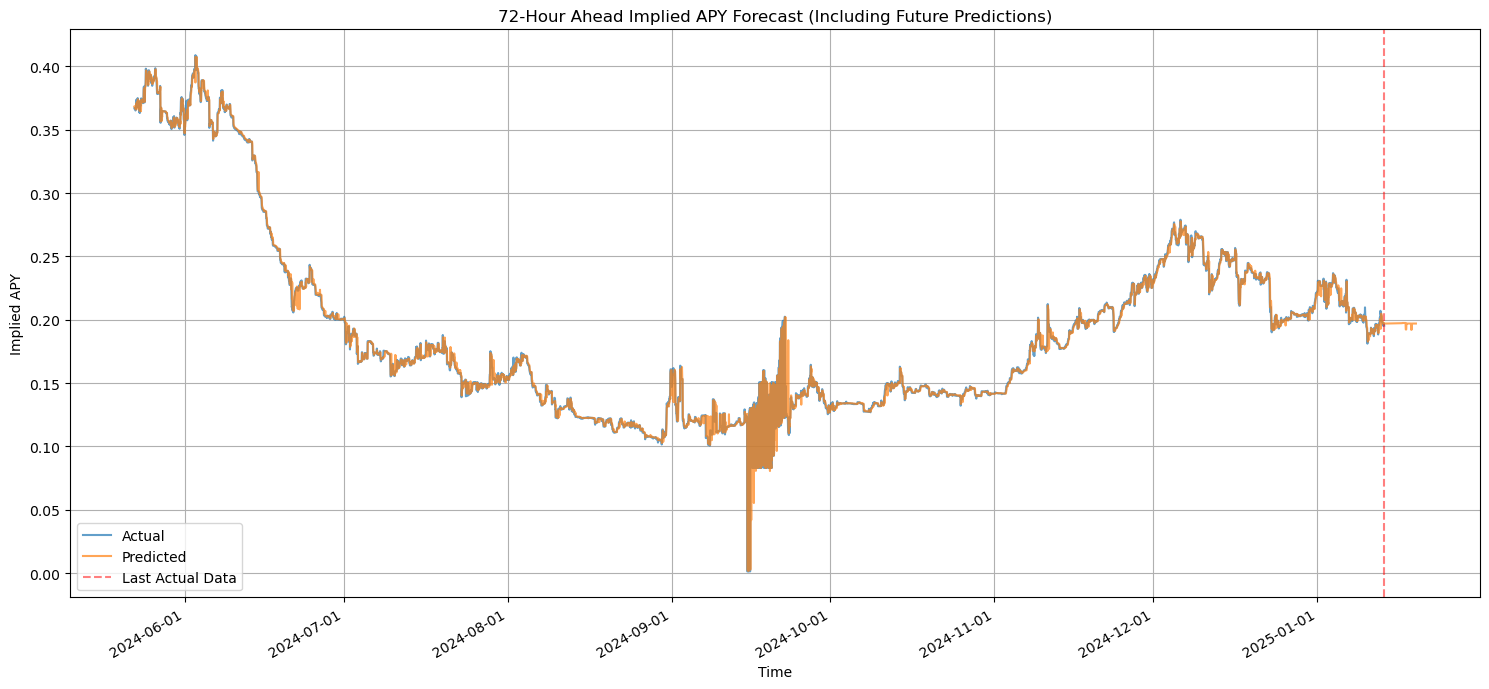


Future Predictions:

Next 72 hours predictions:
            timestamp  predicted
0 2025-01-16 17:00:00   0.197338
1 2025-01-16 18:00:00   0.197338
2 2025-01-16 19:00:00   0.197338
3 2025-01-16 20:00:00   0.197338
4 2025-01-16 21:00:00   0.197338

Last few predictions:
             timestamp  predicted
67 2025-01-19 12:00:00   0.197054
68 2025-01-19 13:00:00   0.197054
69 2025-01-19 14:00:00   0.197054
70 2025-01-19 15:00:00   0.197054
71 2025-01-19 16:00:00   0.197054

Last actual value: 0.1954
First predicted future value: 0.1973


In [34]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from tqdm import tqdm

# Check CUDA availability
try:
    test_model = xgb.XGBRegressor(tree_method='gpu_hist')
    print("GPU acceleration is available!")
    use_gpu = True
except Exception as e:
    print("GPU acceleration is not available. Using CPU instead.")
    print(f"Reason: {str(e)}")
    use_gpu = False

def create_features(data, end_idx):
    """Creates features at a specific point"""
    base_columns = [
        'underlyingApy', 
        'BTC_funding_hourly', 
        'ETH_funding_hourly',
        'USDE_supply', 
        'sUSDE_supply', 
        'USDE_sUSDE_ratio',
        'ena_price',
        'apy_proximity_to_ceiling',
        'apy_proximity_to_floor',
        'apy_volatility',
        'apy_momentum'
    ]
    
    # Get the latest values for each feature at end_idx
    return data.iloc[end_idx][base_columns].values

def predict_future(model, last_data, num_future_steps=72):
    """Make predictions for future timepoints with dynamic feature updates"""
    future_predictions = []
    future_timestamps = []
    
    # Get the last timestamp
    last_timestamp = last_data.index[-1]
    
    # Create a copy of the last data point that we'll update
    current_data = last_data.iloc[[-1]].copy()
    
    # Generate predictions for each future hour
    for i in range(num_future_steps):
        # Create features from current data
        current_features = create_features(current_data, 0)
        
        # Make prediction
        pred = model.predict(current_features.reshape(1, -1))[0]
        future_predictions.append(pred)
        
        # Generate next timestamp
        next_timestamp = last_timestamp + pd.Timedelta(hours=i+1)
        future_timestamps.append(next_timestamp)
        
        # Update features for next prediction
        current_data = current_data.copy()
        
        # Update impliedApy with the prediction
        current_data.loc[current_data.index[0], 'impliedApy'] = pred
        
        # Update volatility and momentum based on new prediction
        if i >= 24:  # Once we have 24 hours of predictions
            current_data.loc[current_data.index[0], 'apy_volatility'] = np.std(future_predictions[-24:])
            current_data.loc[current_data.index[0], 'apy_momentum'] = (
                pred / future_predictions[-24] - 1
            )
        
        # Update proximity indicators
        current_data.loc[current_data.index[0], 'apy_proximity_to_ceiling'] = (0.40 - pred) / 0.30
        current_data.loc[current_data.index[0], 'apy_proximity_to_floor'] = (pred - 0.05) / 0.05
        
        # Update other features with simple trends (you can make this more sophisticated)
        # For example, using moving averages or more complex forecasting
        if i > 0:
            # Update funding rates with small random variations
            for col in ['BTC_funding_hourly', 'ETH_funding_hourly']:
                current_val = current_data[col].iloc[0]
                # Add small random variation (±5% of current value)
                variation = current_val * np.random.uniform(-0.05, 0.05)
                current_data.loc[current_data.index[0], col] = current_val + variation
            
            # Gradually update USDE supply with small increments
            for col in ['USDE_supply', 'sUSDE_supply']:
                current_val = current_data[col].iloc[0]
                # Add small increment (0.1% random growth)
                growth = current_val * np.random.uniform(0, 0.001)
                current_data.loc[current_data.index[0], col] = current_val + growth
            
            # Update ratio
            current_data.loc[current_data.index[0], 'USDE_sUSDE_ratio'] = (
                current_data['sUSDE_supply'].iloc[0] / current_data['USDE_supply'].iloc[0]
            )
    
    # Create future predictions DataFrame
    future_df = pd.DataFrame({
        'timestamp': future_timestamps,
        'predicted': future_predictions
    })
    
    return future_df

# Parameters
prediction_horizon = 72  # We want to predict 72 hours ahead
min_training_samples = 28  # Start with 28 samples as specified

# Initialize model with GPU if available
if use_gpu:
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        tree_method='gpu_hist',
        predictor='gpu_predictor'
    )
else:
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    )

predictions = []
actuals = []
timestamps = []

# Calculate the last possible prediction point
last_prediction_point = len(fulldf) - prediction_horizon

print("Starting rolling predictions...")
with tqdm(total=last_prediction_point - min_training_samples) as pbar:
    for current_idx in range(min_training_samples, last_prediction_point):
        # For each prediction point, use data from beginning up to current_idx
        X_train = []
        y_train = []
        
        # Create training data using points from 0 to current_idx
        for j in range(current_idx - min_training_samples, current_idx):
            features = create_features(fulldf, j)
            X_train.append(features)
            y_train.append(fulldf['impliedApy'].iloc[j + prediction_horizon])
        
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make prediction using current point
        X_pred = create_features(fulldf, current_idx).reshape(1, -1)
        pred = model.predict(X_pred)[0]
        
        # Store results
        predictions.append(pred)
        actuals.append(fulldf['impliedApy'].iloc[current_idx + prediction_horizon])
        timestamps.append(fulldf.index[current_idx])
        
        pbar.update(1)

# Create historical results DataFrame
historical_results = pd.DataFrame({
    'timestamp': timestamps,
    'actual': actuals,
    'predicted': predictions
})

# Generate future predictions
future_results = predict_future(model, fulldf)

# Combine historical and future predictions
final_results = pd.concat([
    historical_results,
    future_results.assign(actual=np.nan)
])

# Calculate metrics for historical predictions
mae = mean_absolute_error(historical_results['actual'], historical_results['predicted'])
mse = mean_squared_error(historical_results['actual'], historical_results['predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(historical_results['actual'], historical_results['predicted'])

print("\nHistorical Performance Metrics:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot results including future predictions
plt.figure(figsize=(15, 7))
plt.plot(final_results['timestamp'], final_results['actual'], 
         label='Actual', alpha=0.7)
plt.plot(final_results['timestamp'], final_results['predicted'], 
         label='Predicted', alpha=0.7)

# Add vertical line at last actual data point
last_actual = final_results['actual'].last_valid_index()
plt.axvline(x=final_results['timestamp'][last_actual], 
            color='r', linestyle='--', alpha=0.5,
            label='Last Actual Data')

plt.title('72-Hour Ahead Implied APY Forecast (Including Future Predictions)')
plt.xlabel('Time')
plt.ylabel('Implied APY')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Print future predictions
print("\nFuture Predictions:")
future_only = final_results[final_results['actual'].isna()]
print("\nNext 72 hours predictions:")
print(future_only[['timestamp', 'predicted']].head())
print("\nLast few predictions:")
print(future_only[['timestamp', 'predicted']].tail())

# Save complete results
final_results.to_csv('predictions_with_future.csv')

# Print the last actual value and first predicted future value
last_actual_value = historical_results['actual'].iloc[-1]
first_future_value = future_only['predicted'].iloc[0]
print(f"\nLast actual value: {last_actual_value:.4f}")
print(f"First predicted future value: {first_future_value:.4f}")

Creating predictor...
Initializing APY Predictor...
Training and predicting...
Preparing training data...
Training model...
Generating predictions...


C:\Users\DC\AppData\Local\Temp\ipykernel_23332\1888695341.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.data = self.data.fillna(method='ffill')



Calculating metrics...

Historical Performance Metrics:
Mean Absolute Error: 0.0055
Root Mean Squared Error: 0.0086
R² Score: 0.9848


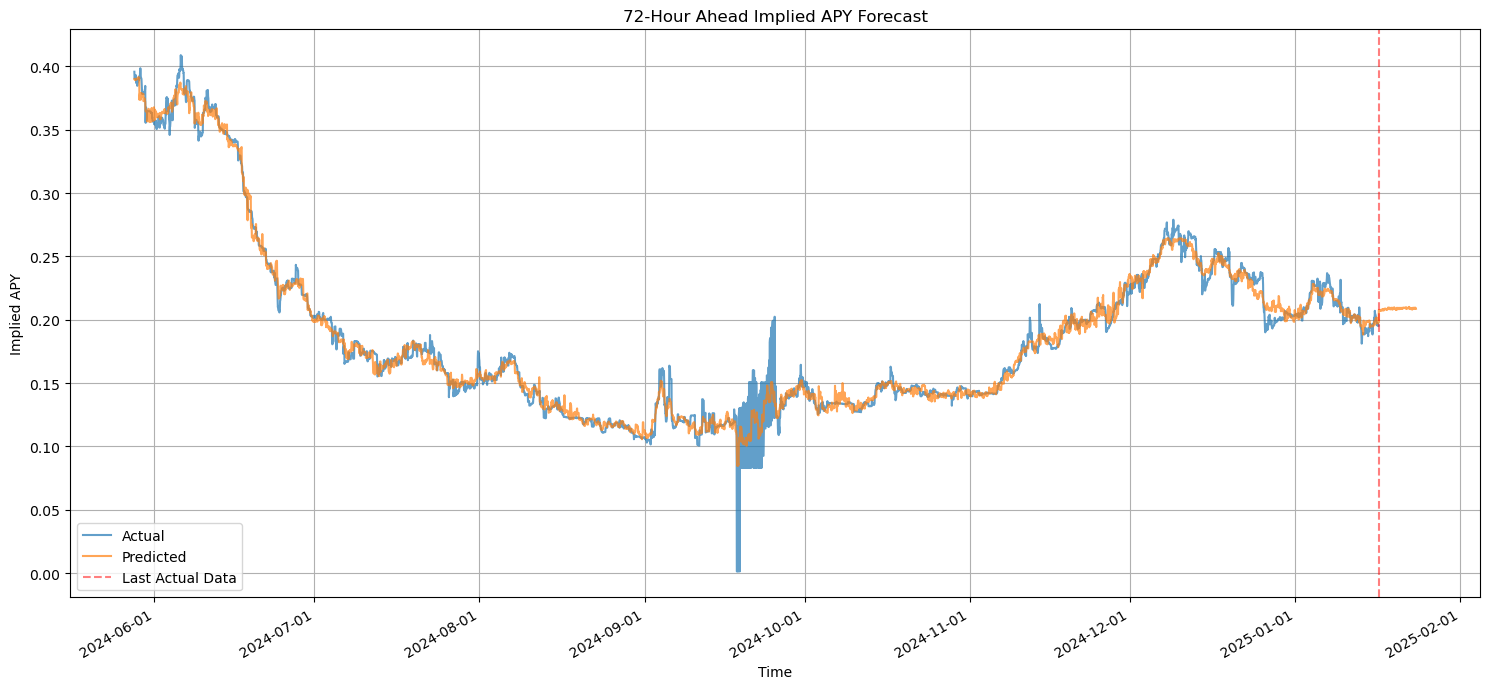


Next 72 hours predictions:
            timestamp  predicted
0 2025-01-16 17:00:00   0.207830
1 2025-01-16 18:00:00   0.207438
2 2025-01-16 19:00:00   0.206840
3 2025-01-16 20:00:00   0.207466
4 2025-01-16 21:00:00   0.207101

Last few predictions:
              timestamp  predicted
163 2025-01-23 12:00:00   0.209701
164 2025-01-23 13:00:00   0.209064
165 2025-01-23 14:00:00   0.209164
166 2025-01-23 15:00:00   0.208630
167 2025-01-23 16:00:00   0.208676

Last actual value: 0.1954
First predicted future value: 0.2078


In [33]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from tqdm import tqdm

class APYPredictor:
    def __init__(self, data, prediction_horizon=168):
        print("Initializing APY Predictor...")
        self.data = data.copy()  # Create a copy to avoid modifying original data
        self.prediction_horizon = prediction_horizon
        self.base_columns = [
            'underlyingApy', 
            'BTC_funding_hourly', 
            'ETH_funding_hourly',
            'USDE_supply', 
            'sUSDE_supply', 
            'USDE_sUSDE_ratio',
            'ena_price',
            'apy_volatility',
            'apy_momentum'
        ]
        
        # Add rolling statistics to data
        self._prepare_data()
        
        # Simplified model with stronger regularization
        self.model = xgb.XGBRegressor(
            n_estimators=500,         # Reduced for less overfitting
            learning_rate=0.2,       # Slower learning rate
            max_depth=168,              # Shallower trees
            min_child_weight=3,       # More conservative splits
            subsample=0.3,            # Sample 70% of data per tree
            colsample_bytree=0.3,     # Sample 70% of features per tree
            reg_alpha=0.5,            # L1 regularization
            reg_lambda=2.0,           # L2 regularization
            random_state=42,
            tree_method='hist',       # Use CPU version for better compatibility
        )
    
    def _prepare_data(self):
        """Add rolling statistics to the data"""
        for col in ['impliedApy', 'underlyingApy']:
            self.data[f'{col}_ma24'] = self.data[col].rolling(24).mean()
            self.data[f'{col}_std24'] = self.data[col].rolling(24).std()
        
        # Forward fill any NaN values created by rolling windows
        self.data = self.data.fillna(method='ffill')
        
    def create_features(self, data_slice):
        """Create feature matrix from data slice"""
        features = data_slice[self.base_columns].copy()
        
        # Add rolling statistics
        for col in ['impliedApy', 'underlyingApy']:
            features[f'{col}_ma24'] = data_slice[f'{col}_ma24']
            features[f'{col}_std24'] = data_slice[f'{col}_std24']
        
        return features.values
    
    def prepare_training_data(self):
        """Prepare training data using sliding window approach"""
        train_end = len(self.data) - self.prediction_horizon
        
        # Use data up to train_end for features
        X_train = self.create_features(self.data.iloc[:train_end])
        
        # Target is impliedApy shifted by prediction_horizon
        y_train = self.data['impliedApy'].iloc[self.prediction_horizon:].values
        
        return X_train, y_train
    
    def predict_future(self, num_future_steps=168):
        """Predict future values with dynamic updates"""
        future_predictions = []
        future_timestamps = []
        
        # Start with the last known state
        current_data = self.data.iloc[-24:].copy()  # Use last 24 hours of data
        last_timestamp = self.data.index[-1]
        
        for i in range(num_future_steps):
            # Update rolling features
            for col in ['impliedApy', 'underlyingApy']:
                current_data[f'{col}_ma24'] = current_data[col].rolling(24).mean()
                current_data[f'{col}_std24'] = current_data[col].rolling(24).std()
            
            # Make prediction for next hour
            current_features = self.create_features(current_data)
            pred = self.model.predict(current_features[-1:].reshape(1, -1))[0]
            
            # Add controlled randomness based on historical volatility
            volatility = current_data['apy_volatility'].iloc[-1]
            noise = np.random.normal(0, volatility * 0.1)  # 10% of current volatility
            pred = max(0.05, min(0.40, pred + noise))  # Ensure pred stays within bounds
            
            next_timestamp = last_timestamp + pd.Timedelta(hours=i+1)
            
            # Create new row with updated values
            new_row = current_data.iloc[-1:].copy()
            new_row.index = [next_timestamp]
            new_row['impliedApy'] = pred
            
            # Update other features with realistic variations
            for col in ['BTC_funding_hourly', 'ETH_funding_hourly']:
                current_val = new_row[col].iloc[0]
                new_row[col] = current_val * (1 + np.random.uniform(-0.01, 0.01))
            
            # Update USDE supply with small growth
            for col in ['USDE_supply', 'sUSDE_supply']:
                current_val = new_row[col].iloc[0]
                new_row[col] = current_val * (1 + np.random.uniform(0, 0.0001))
            
            new_row['USDE_sUSDE_ratio'] = new_row['sUSDE_supply'] / new_row['USDE_supply']
            
            # Update current_data for next iteration
            current_data = pd.concat([current_data[1:], new_row])
            
            future_predictions.append(pred)
            future_timestamps.append(next_timestamp)
        
        return pd.DataFrame({
            'timestamp': future_timestamps,
            'predicted': future_predictions
        })
    
    def train_and_predict(self):
        """Train model and generate predictions"""
        print("Preparing training data...")
        X_train, y_train = self.prepare_training_data()
        
        print("Training model...")
        self.model.fit(X_train, y_train)
        
        print("Generating predictions...")
        # Make predictions on training data
        train_predictions = self.model.predict(X_train)
        
        # Create historical results DataFrame
        historical_results = pd.DataFrame({
            'timestamp': self.data.index[self.prediction_horizon:],
            'actual': y_train,
            'predicted': train_predictions
        })
        
        # Generate future predictions
        future_results = self.predict_future()
        
        # Combine historical and future results
        final_results = pd.concat([
            historical_results,
            future_results.assign(actual=np.nan)
        ])
        
        return final_results, historical_results

def main():
    print("Creating predictor...")
    predictor = APYPredictor(fulldf)

    print("Training and predicting...")
    final_results, historical_results = predictor.train_and_predict()

    # Calculate metrics
    print("\nCalculating metrics...")
    mae = mean_absolute_error(historical_results['actual'], historical_results['predicted'])
    mse = mean_squared_error(historical_results['actual'], historical_results['predicted'])
    rmse = np.sqrt(mse)
    r2 = r2_score(historical_results['actual'], historical_results['predicted'])

    print("\nHistorical Performance Metrics:")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Plot results
    plt.figure(figsize=(15, 7))
    plt.plot(final_results['timestamp'], final_results['actual'], 
             label='Actual', alpha=0.7)
    plt.plot(final_results['timestamp'], final_results['predicted'], 
             label='Predicted', alpha=0.7)

    last_actual = final_results['actual'].last_valid_index()
    plt.axvline(x=final_results['timestamp'][last_actual], 
                color='r', linestyle='--', alpha=0.5,
                label='Last Actual Data')

    plt.title('72-Hour Ahead Implied APY Forecast')
    plt.xlabel('Time')
    plt.ylabel('Implied APY')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

    # Print predictions
    future_only = final_results[final_results['actual'].isna()]
    print("\nNext 72 hours predictions:")
    print(future_only[['timestamp', 'predicted']].head())
    print("\nLast few predictions:")
    print(future_only[['timestamp', 'predicted']].tail())

    # Save results
    final_results.to_csv('predictions_with_future.csv')

    # Print final values
    last_actual_value = historical_results['actual'].iloc[-1]
    first_future_value = future_only['predicted'].iloc[0]
    print(f"\nLast actual value: {last_actual_value:.4f}")
    print(f"First predicted future value: {first_future_value:.4f}")

if __name__ == "__main__":
    main()